### Written by  [Gabriel Borges Pinheiro](github.com/gabrielbopi) & Wissam Melo

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#### Creating the test environment

In [2]:
def bases(D, x, y, alt=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),alt])) 
        
    return total, n.reshape(total,3)

def usuário(n, x, y):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),1.5]))
    return UE.reshape(n,3)

In [3]:
def BSs_per_UE(BS, UE, total):
    endereços = []

    for n in range(num_ue):
        BS_UE = np.array([])
        conectadas = 0
        for i in range(total):
            dist = np.linalg.norm(BS[i]-UE[n])
            if dist <= 50:
                conectadas += 1
                BS_UE = np.append(BS_UE, BS[i])
        BS_UE = np.append(BS_UE, 0)
        endereços = np.append(endereços,BS_UE)
  
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(endereços) 
    idx_list = [idx + 1 for idx, val in enumerate(endereços) if val == 0] 
    res = [endereços[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    
    for i in range(len(res)):
        indices = np.where(res[i]==0)
        res[i] = np.delete(res[i], indices)
        res[i] = res[i].reshape(int((res[i].shape[0])/3),3)
    res = np.array(res)
    return res

In [4]:
def UEs_per_BS(BS, UE, total):
    positions = []

    for n in range(total):
        BS_UE = np.array([])
        conectados = 0
        for i in range(len(UE)):
            dist = np.linalg.norm(BS[n]-UE[i])
            if dist <= 50:
                conectados += 1
                BS_UE = np.append(BS_UE, UE[i])
        BS_UE = np.append(BS_UE, 0)
        positions = np.append(positions,BS_UE)
    
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(positions) 
    idx_list = [idx + 1 for idx, val in enumerate(positions) if val == 0]
    antenna = [positions[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 

    for i in range(len(antenna)):
        indices = np.where(antenna[i]==0)
        antenna[i] = np.delete(antenna[i], indices)
        antenna[i] = antenna[i].reshape(int((antenna[i].shape[0])/3),3)
    return antenna

##### Generating BSs and UEs

In [5]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Number of users
num_ue = 1

total,BS = bases(gap_bs, 200, 100)
UE = usuário(num_ue, 200, 100)
UEs_antenna = UEs_per_BS(BS, UE, total)
BSUE = BSs_per_UE(BS, UE, total)

In [6]:
BS

array([[ 25.,  25.,  15.],
       [ 75.,  25.,  15.],
       [125.,  25.,  15.],
       [175.,  25.,  15.],
       [ 25.,  75.,  15.],
       [ 75.,  75.,  15.],
       [125.,  75.,  15.],
       [175.,  75.,  15.]])

In [7]:
UE

array([[138.15566604,  18.53574499,   1.5       ]])

In [8]:
UEs_antenna

[array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[138.15566604,  18.53574499,   1.5       ]]),
 array([[138.15566604,  18.53574499,   1.5       ]]),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64)]

In [9]:
len(UEs_antenna)

8

In [10]:
BSUE

array([[[125.,  25.,  15.],
        [175.,  25.,  15.]]])

#### Calculating the parameters

In [11]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [12]:
def β_channel(D):
    """
    Returns the 
    """
    #Carrier frequency (LTE band 7)
    f = 2.6e9
    #Wavelength
    λ = 3e8/f
    R = D
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    β = L_lin
    return β

def rand_channel(D, N):
    """
    Returns the channel
    """
    β = β_channel(D)
    ampl = np.sqrt(β)/2
    h = (np.random.randn(N) + 1j*np.random.randn(N)) * ampl
    return h

def channel_user2(num_ue,numBS,nAntennas,UEpos,BSpos,UEs_antenna):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    H = np.zeros((num_ue,numBS,nAntennas),dtype=complex)

    for ii in range(numBS):
        for jj in range(UEs_antenna[ii].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[ii][jj] - UEpos),axis=1))
            R = np.linalg.norm(BSpos[ii] - UEs_antenna[ii][jj]) 
            H[int(user)][ii] = rand_channel(R, nAntennas)

    return H

def powerUE(num_ue, total, UEpos,UEs_antenna, P_dBm):
    p = np.zeros(num_ue)
    for i in range(total):
        UE_BS = UEs_antenna[i].shape[0]
        for j in range(UEs_antenna[i].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[i][j] - UEpos),axis=1))
            p[int(user)] =  p[int(user)] + (inv_dbm(P_dBm)/int(UE_BS))
    return dbm(p)

def get_beamforming(h, num_ue, total, P_dBm):
    p = inv_dbm(P_dBm)
    v = np.zeros((num_ue,total*N), dtype = 'complex_')
    for i in range(num_ue):
        v[i] = np.sqrt(p[i])*(np.conjugate(h[i])/np.linalg.norm(h[i]))
        
    return v

In [13]:
P_dBm = 40
P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
P_dBm

array([43.01029996])

In [14]:
#Numero de antenas no arranjo
N = 5

#h = channel_user(N, UE, total, BSUE)
H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)

In [15]:
H

array([[[ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [-1.84491075e-04-4.67170963e-04j,
         -3.76167891e-04+2.81935371e-04j,
         -2.82120877e-04-1.36339587e-04j,
          4.73684304e-04+3.63261234e-04j,
         -1.33622226e-04+1.61388447e-04j],
        [-1.27708396e-04-3.12120784e-04j,
         -1.17006975e-04+6.81658060e-05j,
         -3.06660915e-05-7.65999544e-05j,
         -5.23202102e-05+1.62871597e-04j,
         -5.64262027e-05+1.85530521e-05j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.000

In [16]:
BSUE[0].shape[0]

2

In [17]:
def vectorize(H, num_ue, total, N):
    h = np.zeros((num_ue, N*total), dtype ='complex_')
    for i in range(num_ue):
        h[i] = H[i].reshape(N*total)
    return h

H = vectorize(H, 1, total, N)

In [18]:
H

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -1.84491075e-04-4.67170963e-04j, -3.76167891e-04+2.81935371e-04j,
        -2.82120877e-04-1.36339587e-04j,  4.73684304e-04+3.63261234e-04j,
        -1.33622226e-04+1.61388447e-04j, -1.27708396e-04-3.12120784e-04j,
        -1.17006975e-04+6.81658060e-05j, -3.06660915e-05-7.65999544e-05j,
        -5.23202102e-05+1.62871597e-04j, -5.64262027e-05+1.85530521e-05j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00

In [19]:
v = get_beamforming(H, num_ue, total, P_dBm)

In [20]:
v

array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
        -0.77161196+1.95388695j, -1.57327743-1.17916113j,
        -1.17993699+0.57022409j,  1.98112822-1.51929687j,
        -0.55885905-0.67498797j, -0.53412516+1.30540803j,
        -0.48936775-0.28509537j, -0.12825728+0.32037019j,
        -0.21882305-0.68119107j, -0.23599588-0.07759593j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.   

In [21]:
#Band of signal
B = 1e6 #Hz
#Power of noise (-127dBm is average)
N0 = inv_dbm(-127)
σ = B*N0

In [22]:
σ

1.9952623149688826e-10

In [23]:
def sinr(h, V, j, σ):
    
    num = np.abs(V[j].transpose()@h)**2
    den = np.zeros(num.shape)
    for x in range(V.shape[0]):
        #if V[x]:
        if x!=j:
            #den = np.add(den, np.abs(V[x].transpose()@h)**2)
            den += np.abs(V[x].transpose()@h)**2
    return (num/(den+σ))

In [24]:
j = 0
s_inr = sinr(H[j], v, j, σ)

In [25]:
s_inr

114607.4400798683

In [26]:
print(db(s_inr))

50.5921281205326


In [27]:
S = np.zeros(len(UE))
for i in range(len(UE)):
    S[i] = sinr(H[i], v, i, σ)


In [28]:
print(np.sum(np.log2(S+1)))
#C

16.806353766463616


In [29]:
BS.shape[0]

8

In [30]:
def sinr_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C

[0.99892126 0.99906209 0.99934413 0.99992093 0.99993916 0.99997993
 0.99998059 0.99999288 0.99999349 0.99999586 0.99999637 0.99999731
 0.99999773 0.99999835 0.99999849 0.99999899 0.99999908 0.99999912
 0.99999939 0.99999944 0.99999972 0.99999972 0.99999976 0.9999998
 0.9999999  0.99999992 0.99999993 0.99999996 0.99999996 0.99999998
 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999 0.99999999
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.      

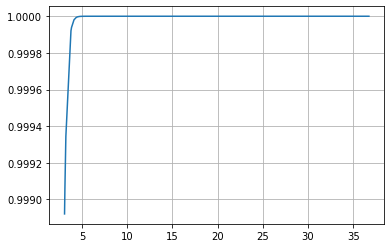

In [39]:
mc = 1000
C = np.zeros(mc)
for j in range(mc):
    np.random.seed(j)
    C[j] = sinr_mc(2, N, BS, P_dBm)
hist = norm.cdf(np.sort(C))
print(CDF)
print(C.shape)
print(np.std(C))
label = ('{} users'.format(2))
plt.plot(np.sort(C), CDF, label=label)
plt.grid()

In [32]:
print(sinr_mc(1, N, BS, 40))

15.914972188187683


In [49]:
n = [1,2,4,6,8]#,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,64,80,100,128]
us = [1,2,8,16]#,24,32,40,45,50,55,64,80,100,128]

In [34]:
type(n[i])

int

In [56]:
def cdf(C):
    hist, bins = np.histogram(C, bins=20)
    pdf_C = hist/np.sum(hist)
    cdf_C = np.cumsum(pdf_C)
    return cdf_C, pdf_C, bins

n - 1
n - 2
n - 8
n - 16


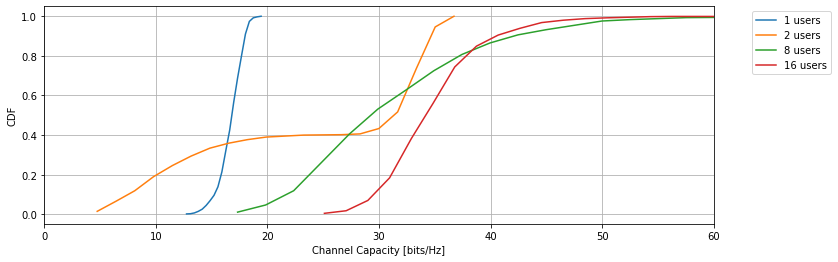

In [58]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(us)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(us[i], N, BS, P_dBm)
    CDF, PDF, BINS = cdf(C)
    #AVG = np.append(AVG, avg)
    label = ('{} users'.format(us[i]))
    plt.plot(BINS[1::], CDF, label=label)
    print("n - " + str(us[i]))
plt.ylabel("CDF")
plt.xlabel("Channel Capacity [bits/Hz]")
plt.xlim(0,60)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

n - 1
n - 2
n - 4
n - 6
n - 8
n - 10
n - 12
n - 14
n - 16
n - 18
n - 20
n - 22
n - 24
n - 26
n - 28
n - 30
n - 32
n - 34
n - 36
n - 38
n - 40
n - 64
n - 80
n - 100
n - 128


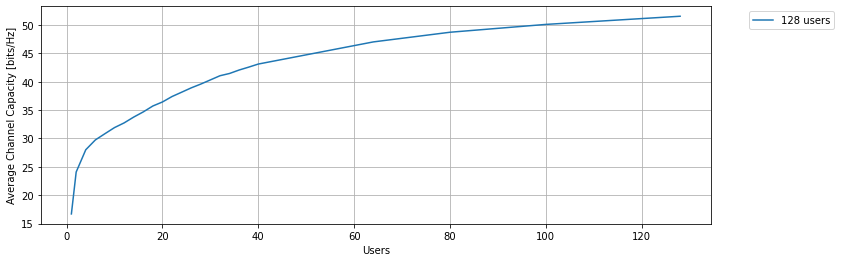

In [51]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(n[i], N, BS, P_dBm)
    CDF, avg = cdf(C)
    AVG = np.append(AVG, avg)
    label = ('{} users'.format(n[i]))
    print("n - " + str(n[i]))
plt.plot(n, AVG, label=label)
plt.ylabel("Average Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

##### Sem clusterização

In [57]:
[UE]

[array([[149.31086476,  87.58907112,   1.5       ]])]

In [36]:
def sem_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = [UE,UE,UE,UE,UE,UE,UE,UE]
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C

n - 1
n - 2
n - 8
n - 16


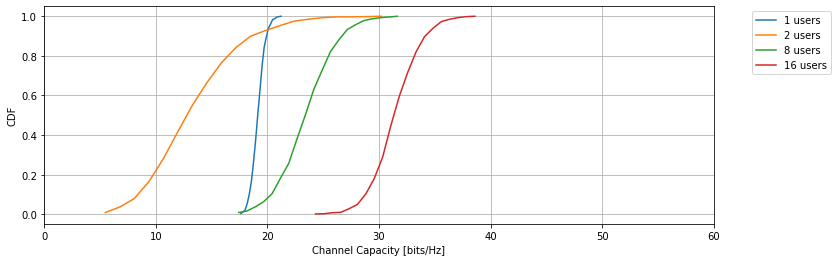

In [59]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(us)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sem_mc(us[i], N, BS, P_dBm)
    CDF, PDF, BINS = cdf(C)
    AVG = np.append(AVG, avg)
    label = ('{} users'.format(us[i]))
    plt.plot(BINS[1::], CDF, label=label)
    print("n - " + str(us[i]))
plt.ylabel("CDF")
plt.xlabel("Channel Capacity [bits/Hz]")
plt.xlim(0,60)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

n - 1
n - 2
n - 4
n - 6
n - 8
n - 10
n - 12
n - 14
n - 16
n - 18
n - 20
n - 22
n - 24
n - 26
n - 28
n - 30
n - 32
n - 34
n - 36
n - 38
n - 40
n - 64
n - 80
n - 100
n - 128


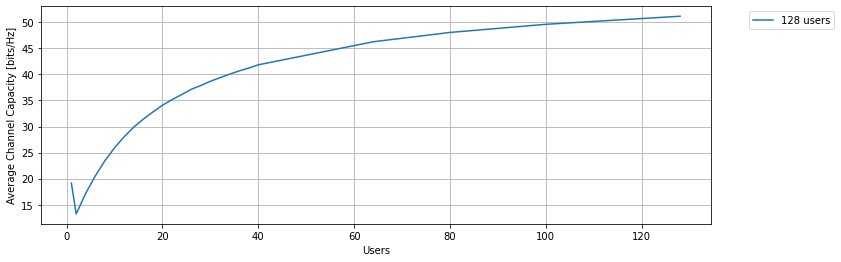

In [38]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sem_mc(n[i], N, BS, P_dBm)
    CDF, avg = cdf(C)
    AVG = np.append(AVG, avg)
    label = ('{} users'.format(n[i]))
    print("n - " + str(n[i]))
plt.plot(n, AVG, label=label)
plt.ylabel("Average Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()